Ejercicio 3 - Regresión
Grupo 8

---

Integrantes:<br>
  Avalos, Camila Lucia<br>
  Benitez Potochek, Tomás<br>
  Roldan Montes, Cristian<br>
  Sprenger, Roberta

Queremos predecir el precio de las publicaciones en AirBnB para la zona de Los Ángeles, California, EEUU.

In [1]:
!pip install category_encoders

Obtenemos el dataset

In [2]:
data_url = 'https://data.insideairbnb.com/united-states/ca/los-angeles/2024-09-04/data/listings.csv.gz'

In [3]:
import requests
from concurrent.futures import ThreadPoolExecutor
def download_file(url):
    response = requests.get(url)
    if "content-disposition" in response.headers:
        content_disposition = response.headers["content-disposition"]
        filename = content_disposition.split("filename=")[1]
    else:
        filename = url.split("/")[-1]
    with open(filename, mode="wb") as file:
        file.write(response.content)


download_file(data_url)

In [4]:
!pip install patool
import patoolib
patoolib.extract_archive("./listings.csv.gz")

INFO patool: Extracting ./listings.csv.gz ...
INFO:patool:Extracting ./listings.csv.gz ...
INFO patool: running /usr/bin/7z e -o./Unpack_5rlub474 -- ./listings.csv.gz
INFO:patool:running /usr/bin/7z e -o./Unpack_5rlub474 -- ./listings.csv.gz
INFO patool:     with input=''
INFO:patool:    with input=''
INFO patool: ... ./listings.csv.gz extracted to `listings.csv2' (local file exists).
INFO:patool:... ./listings.csv.gz extracted to `listings.csv2' (local file exists).


'listings.csv2'

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [6]:
bnb_dtype = {}

int_types = {'id', 'scrape_id', 'host_id', 'host_listings_count',
       'host_total_listings_count', 'accommodates', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights', 'calendar_updated',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', }

float_types = {'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm','latitude', 'longitude',
       'bathrooms','review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value','reviews_per_month'}

object_types = {'listing_url', 'last_scraped', 'source', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_url', 'host_name',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'property_type', 'room_type',
       'bathrooms_text', 'amenities', 'price', 'has_availability',
       'calendar_last_scraped', 'first_review', 'last_review', 'license',
       'instant_bookable'}

datetime_types = {
    "first_review",
    "last_review",
    "calendar_last_scraped",
    'host_since',
    'last_scraped'
    }

bnb_dtype |= {x:'Int32' for x in int_types}
bnb_dtype |= {x:'Float64' for x in float_types}
bnb_dtype |= {x:str for x in object_types}


data_bnb = pd.read_csv("listings.csv", dtype=bnb_dtype)
# data_bnb = pd.read_csv("listings.csv")

In [7]:
data_bnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45533 entries, 0 to 45532
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            45533 non-null  Int32  
 1   listing_url                                   45533 non-null  object 
 2   scrape_id                                     45533 non-null  Int32  
 3   last_scraped                                  45533 non-null  object 
 4   source                                        45533 non-null  object 
 5   name                                          45532 non-null  object 
 6   description                                   44100 non-null  object 
 7   neighborhood_overview                         23112 non-null  object 
 8   picture_url                                   45533 non-null  object 
 9   host_id                                       45533 non-null 

# Procesamiento preliminal

In [8]:
data_bnb.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,45533.0,45533.0,45533.0,45531.0,45531.0,45533.0,45533.0,45533.0,37294.0,42494.0,...,33377.0,33370.0,33377.0,33369.0,33368.0,45533.0,45533.0,45533.0,45533.0,33387.0
mean,10321404.663738,-1276701838.0,195047282.241407,96.19356,125.0235,34.055308,-118.312743,4.019876,1.649434,1.786817,...,4.745298,4.85824,4.857009,4.795567,4.701468,18.604155,16.186941,1.83904,0.216766,1.45802
std,914026187.215229,0.0,189982500.842077,573.747283,686.43593,0.141394,0.17221,2.86161,1.218398,1.339151,...,0.435656,0.358541,0.371343,0.373467,0.451462,66.312446,65.906293,7.198427,2.059845,1.719427
min,-2146769211.0,-1276701838.0,521.0,0.0,0.0,33.33836,-118.917134,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.01
25%,-194035965.0,-1276701838.0,26326994.0,1.0,2.0,33.99859,-118.41309,2.0,1.0,1.0,...,4.68,4.86,4.87,4.75,4.64,1.0,1.0,0.0,0.0,0.22
50%,29287713.0,-1276701838.0,116563143.0,3.0,5.0,34.060625,-118.343391,3.0,1.0,1.0,...,4.88,4.97,4.97,4.91,4.81,2.0,1.0,0.0,0.0,0.79
75%,173892947.0,-1276701838.0,371231553.0,12.0,18.0,34.10816,-118.233737,6.0,2.0,2.0,...,5.0,5.0,5.0,5.0,4.96,9.0,6.0,1.0,0.0,2.23
max,2147258905.0,-1276701838.0,599749717.0,4494.0,9019.0,34.811183,-117.653352,16.0,50.0,50.0,...,5.0,5.0,5.0,5.0,5.0,569.0,569.0,89.0,34.0,55.49


no nos interesan las filas que no tienen precio, ya que es la variable que queremos predecir y por lo tanto no nos sirven para entrenar ni validar.

In [9]:
data_bnb.dropna(subset=["price"], inplace=True)

el dataset contiene muchos datos distintos para cada publicacion, algunos de ellos siendo completamente irrelevantes o inutiles para nuestro trabajo (como el "id", la url, etc) o bien requieren algun procesamiento extra para tenerlas en un estado útil para nuestros algoritmos the machine learning (el precio es un string).

Las enumeramos en conjuntos para tenerlas categorizadas y hacer uso de esta información.

In [10]:
long_columns = {
    "listing_url",
    "name",
    "description",
    "picture_url",
    "host_url",
     "host_about",
    "host_thumbnail_url",
    "host_picture_url",
    "neighborhood_overview",
    "host_picture_url",
}

irrelevant_columns = {
    "id",
    "scrape_id",
    "listing_url",
    "name",
    "description",
    'picture_url',
    'host_url',
    'host_name',
    "host_about",
    "host_id",
    "host_thumbnail_url",
    "host_location",
    "neighbourhood", # 1 solo dato
    "calendar_last_scraped",
}


compound_columns = {
    "host_verifications",
    "amenities",
}

categorical_columns = {
    "host_is_superhost",
    "host_has_profile_pic",
    "host_identity_verified",
    "has_availability",
    "instant_bookable",
    "host_neighbourhood",
    "neighbourhood_cleansed",
    "neighbourhood_group_cleansed",
    "property_type",
    "room_type",
}

pseudonumerical_columns = {
    "price",
    "host_response_rate",
    "host_acceptance_rate",
    "bathrooms_text",

}

## Datos faltantes

Tambien vemos la proporcion de datos faltantes en los features

In [11]:
nans = data_bnb.isna().sum() / len(data_bnb)

In [12]:
nans.sort_values(ascending=False).head(30)

,0
calendar_updated,1.000000
license,0.695168
neighborhood_overview,0.496863
neighbourhood,0.496863
host_about,0.452515
review_scores_value,0.246059
review_scores_location,0.246059
review_scores_checkin,0.246032
review_scores_cleanliness,0.245978
review_scores_accuracy,0.245951


Vemos que más de 15 features presentan una proporción importante de datos faltantes que a priori no sabemos si son importantes o no.

Por ahora, solo consideramos descartar las features que presentan más del 30% de datos faltantes

In [13]:
dropped = nans.loc[lambda s:s > 0.3].index
print(list(dropped))

['neighborhood_overview', 'host_about', 'neighbourhood', 'calendar_updated', 'license']


In [14]:
data_bnb.drop(columns=dropped, inplace=True)

## columna "amenities"

cada listing lista las comodidades que provee. Estos estan en el dataset como listas de strings. Vemos de obtener un conjunto de todas las comodidaes presentes en el dataset.

In [15]:
def parse_amenities(amenities: str):
  a = amenities.strip("[]")
  ls = a.split(',')
  ls = [x.strip(' "') for x in ls]
  return set(ls)

In [16]:
x = data_bnb.apply(lambda row: parse_amenities(row["amenities"]), axis=1)

In [17]:
res = set()
for i in x:
  res |= i

In [18]:
for am in list(res)[:10]:
  print(am)


Commercial brand conditioner
86 inch HDTV with Fire TV
Raw Sugar  conditioner
42 inch HDTV with Amazon Prime Video
24 inch HDTV with Roku
Careless Olay dove  body soap
Frigidaire refrigerator
Trader joes or similar conditioner
Dacor stainless steel double oven


In [19]:
len(res)

7446

obtenemos un conjunto de más de siete mil opciones. Esto interpretado como una feature categórica lleva a que es un feature muy grande. por ejemplo, de ser encodeado en forma one hot, llevaria el modelo a mas de siete mil dimensiones solo por esta feature. Tampoco existe una relacion de orden entre ellas, por lo que otras forma de encodeo llevarian a sesgos. Decidimos no usar esta feature.

Lo ideal sería poder procesar este texto en lenguaje natural para crear una feature que permita categorizarlos en base a un conjunto reducido de opciones que transmitan la idea general de cada uno, de forma de obtener un feature más manejable y con más sentido. Posiblemente asigando un puntaje a cada categoría en base a cuanto provee esta publicación en esos aspectos.

## Procesamiento de columnas pseudo-numericas

Algunas columnas requieren un tratamiento especial debido a la manera en que vienen escritos en el set original.

convertimos las columnas numericas que venian encodeadas con characteres
estan son:
* `price`
* `host_acceptance_rate`
* `host_response_rate`

Y otras categoricas que tienen datos numericos redundantes. Pueden descartarse.
* `bathrooms_text`

Estas deberian ser datetime
* `first_review`
* `last_review`
* `calendar_last_scraped`
* `host_since`



In [20]:
data_bnb["price"] = data_bnb["price"].apply(lambda x:x.strip(" $").replace(",","")).astype("Float64")
float_types.add("price")
object_types.remove("price")

In [21]:
data_bnb["host_acceptance_rate"] = data_bnb.loc[data_bnb["host_acceptance_rate"].notna()]["host_acceptance_rate"].map(lambda x:int(x.strip(" %"))/100).astype("Float64")
data_bnb["host_response_rate"] = data_bnb.loc[data_bnb["host_response_rate"].notna()]["host_response_rate"].map(lambda x:int(x.strip(" %"))/100).astype("Float64")

object_types.remove("host_acceptance_rate")
object_types.remove("host_response_rate")

float_types.add("host_acceptance_rate")
float_types.add("host_response_rate")

In [22]:
data_bnb.last_review = pd.to_datetime(data_bnb.last_review, format='%Y-%m-%d')
data_bnb.first_review = pd.to_datetime(data_bnb.first_review, format='%Y-%m-%d')
data_bnb.calendar_last_scraped = pd.to_datetime(data_bnb.calendar_last_scraped, format='%Y-%m-%d')
data_bnb.host_since = pd.to_datetime(data_bnb.host_since, format='%Y-%m-%d')

# Analisis

## Visualizaciones

### cantidad de publicaciones por host

Cada host puede tener más de una propiedad publicada para alquilar. Vemos como se distribuye a grandes rasgos la cantidad de publicaciones por host. Esperamos que la gran mayoría de los hosts tengan 1 sola propiedad en alquiler, seguido de hosts con 2 en alquiler, y así.

In [23]:
listings_per_host = data_bnb[['host_id', 'id']].groupby('host_id').size().reset_index(name='count')
hosts_per_count = listings_per_host.groupby('count').size().reset_index(name='number_of_hosts')

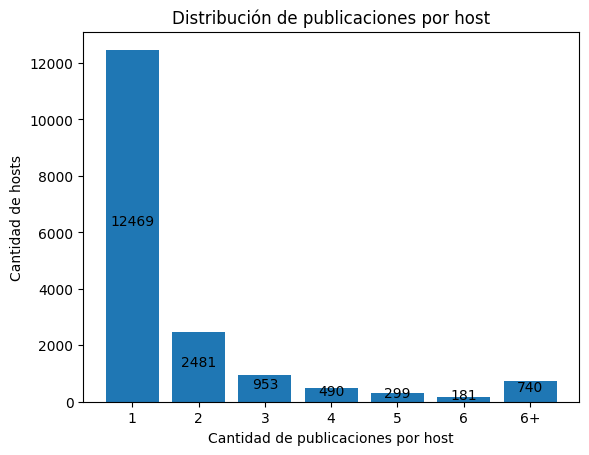

In [24]:
fig, ax = plt.subplots(1, 1)

cutoff = 6
_datax = list(hosts_per_count['count'][:cutoff].apply(str))
_datax = np.append(_datax, f'{cutoff}+')
_datay = np.copy(hosts_per_count['number_of_hosts'][:cutoff].values)
_datay = np.append(_datay, hosts_per_count.loc[lambda df: df['count'] > cutoff].sum()['number_of_hosts'])

ax.bar(_datax, _datay)

for i in range(len(_datax)):
  ax.text(i, _datay[i]//2, _datay[i], ha = 'center')

ax.set_xlabel('Cantidad de publicaciones por host')
ax.set_ylabel('Cantidad de hosts')
ax.set_title('Distribución de publicaciones por host');

### Tipos de alquiler




In [25]:
room_type_count = data_bnb[['room_type']].groupby('room_type').size().reset_index(name='rt_count')
room_type_count

,room_type,rt_count
0,Entire home/apt,28789
1,Hotel room,116
2,Private room,7885
3,Shared room,506


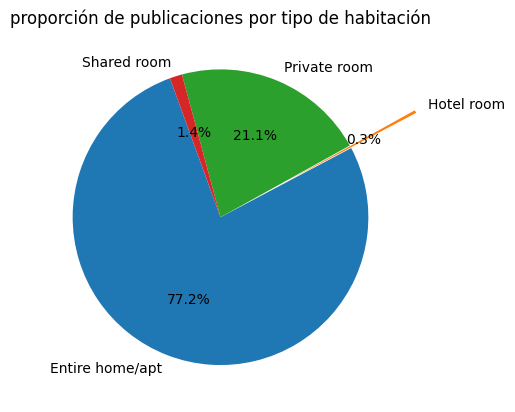

In [26]:
total = room_type_count['rt_count'].sum()

fig, ax = plt.subplots(1,1)

smallest = room_type_count['rt_count'].idxmin()

explode = [0]*len(room_type_count)
explode[smallest] = 0.5

ax.pie(room_type_count['rt_count'].map(lambda x: x/total * 100),
       explode=explode,
       labels=room_type_count['room_type'],
       startangle=110,
       autopct='%1.1f%%')

ax.set_title('proporción de publicaciones por tipo de habitación');

In [27]:
property_type_count = data_bnb[['property_type']].groupby('property_type').size().reset_index(name='pt_count')

total = property_type_count['pt_count'].sum()
property_type_count['percentage'] = property_type_count['pt_count'].map(lambda x:x/total * 100)
property_type_count.sort_values(by='percentage', ascending=False, inplace=True)

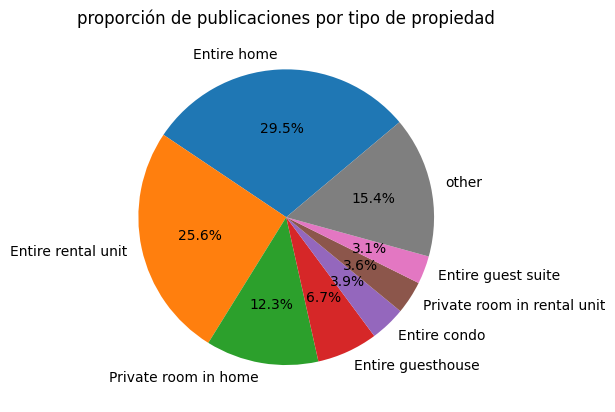

In [28]:
threshold = 2 # 2%

d = property_type_count.loc[lambda df: df['percentage'] > threshold]
rest = property_type_count.loc[lambda df: df['percentage'] <= threshold]
r = rest['percentage'].sum()

datay = np.copy(d['percentage'].values)
datay = np.append(datay, r)
datax = list(d['property_type'].values)
datax.append('other')

fig, ax = plt.subplots(1,1)


ax.pie(datay,
       labels=datax,
       startangle=40,
       autopct='%1.1f%%')

ax.set_title('proporción de publicaciones por tipo de propiedad');

Vemos que los tipos de propiedad en el set de datos es variado pero la distribución no es uniforme. Tan solo 2 tipos forman la mitad de todas las publicaciones

### Precio por tipo de propiedad

In [29]:
price_by_pt = data_bnb[['property_type', 'price']].groupby('property_type')
mean_price_by_pt = price_by_pt.agg('mean')
mean_price_by_pt.sort_values(by='price', ascending=False, inplace=True)
mean_price_by_pt.reset_index(inplace=True)

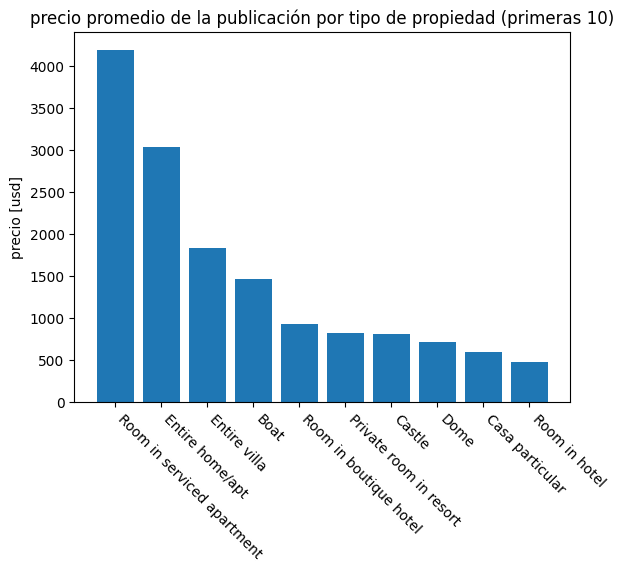

In [30]:
fig, ax = plt.subplots(1,1)
cantidad = 10
ax.bar(mean_price_by_pt['property_type'][:cantidad], mean_price_by_pt['price'][:cantidad])
ax.set_title(f'precio promedio de la publicación por tipo de propiedad (primeras {cantidad})')
ax.set_ylabel('precio [usd]')
plt.xticks(rotation=-45, ha='left');

Tambien vemos que esos 2 mismos tipos de propiedad tienden a ser ls publicaciones más caras.

### Capitalización de mercado por tipo de propiedad

In [31]:
df = data_bnb[['property_type', 'price']].groupby('property_type').agg('sum')
pt_price_count = property_type_count.merge(df, on='property_type')

In [32]:
pt_price_count['capitalization'] = pt_price_count['price'] * pt_price_count['percentage'] / 100
pt_price_count.sort_values(by='capitalization', inplace=True, ascending=False)

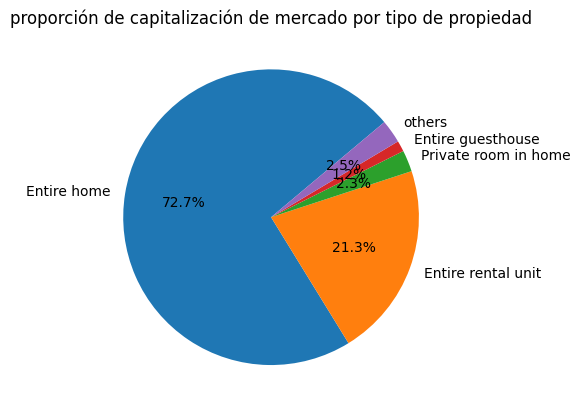

In [33]:

threshold = 4 # top 4

d = pt_price_count[:threshold]
rest = pt_price_count[threshold:]
r = rest['capitalization'].sum()

datay = np.copy(d['capitalization'].values)
datay = np.append(datay, r)
datax = list(d['property_type'].values)
datax.append('others')

fig, ax = plt.subplots(1,1)


ax.pie(datay,
       labels=datax,
       startangle=40,
       autopct='%1.1f%%')

ax.set_title('proporción de capitalización de mercado por tipo de propiedad');

Esto nos muestra que el mercado esta casi completamente dominado por publicaciones de tipo `entire home` (más del 70% del mercado) aun cuando tienen una proporcioón similar al segundo tipo más común ("entire home": 29%, "entire rental unit": 25%).  

# Preparación para el aprendizaje

## Determinacion features más importantes

Como es un dataset relativamente grande en terminos de filas asi como columnas (además de que muchas son a su vez de tipo categóricas), la idea es entrenar un modelo simple con todo el set de datos a fines de obtener algo de información acerca de la correlación entre estas features y la feature que queremos predecir. Simplemente nos ayuda a elegir un subconjunto de estas features que sean las posiblemente más importantes para luego usar al entrenar los modelos "reales".

Elegimos usar un random forests ya que es simple, capaz de lidiar con features numericas como categóricas y ademas puede trabajar con datos faltantes automáticamente.

empezamos dejando las columnas irrelevantes si como otras que consideramos a priori no tan importantes y que solo llevarian a perder más tiempo. No consideramos que los datos temporales sobre las primeras o ultimas reseñas sean muy importantes en cuanto a predecir el precio (a diferencia de otras como la cantidad o puntaje de las reseñas)

In [76]:
to_use = set(data_bnb.columns)
to_use -= datetime_types | long_columns | irrelevant_columns | compound_columns | {'bathrooms_text', 'license'}
X = data_bnb[list(to_use)]

In [78]:
cols = X.select_dtypes(include=['object'])
cols.columns

Index(['neighbourhood_group_cleansed', 'host_identity_verified',
       'neighbourhood_cleansed', 'host_has_profile_pic', 'instant_bookable',
       'room_type', 'host_response_time', 'source', 'property_type',
       'host_neighbourhood', 'has_availability', 'host_is_superhost'],
      dtype='object')

In [79]:
import category_encoders as ce

In [80]:
encoder = ce.OneHotEncoder(cols=cols.columns, handle_unknown='value')

In [81]:
X = encoder.fit_transform(X)

In [83]:
from sklearn.ensemble import RandomForestRegressor

In [84]:
X,Y = X.drop(columns=["price"]), X["price"]

In [85]:
model = RandomForestRegressor(random_state=491204723, n_jobs=-1, n_estimators=100, max_depth=15)

In [86]:
model.fit(X,Y)

RandomForestRegressor(max_depth=15, n_jobs=-1, random_state=491204723)

In [87]:
importances = model.feature_importances_
del model

In [88]:
importances = pd.DataFrame(index=X.columns, data=importances)

Haremos un pequeño procesamiento sobre los datos de importancia obtenidos, ya que estos se refieren a las features encodeadas pero nos interesan las importancias del feature antes de encodear por One Hot Encoding, por lo que debemos sumarlos.

In [89]:
def calc_importances(importances_df, encoder):
  df = {}
  all_cols = set()
  for mapping in encoder.mapping:
    importance_sum = 0.
    col = mapping['col']
    encoded_cols = mapping['mapping']
    all_cols |= set(encoded_cols)
    for feature in encoded_cols.columns:
      importance_sum += importances_df.loc[feature][0]
    df[col] = [importance_sum]

  columns = set(importances_df.index) - all_cols
  columns = list(columns)

  return pd.concat([importances_df.loc[columns], pd.DataFrame(df).transpose()])

In [90]:
im = calc_importances(importances, encoder)

In [91]:
del X
del Y

solo como pequeño testeo, vemos que las importancias siguen sumando 1, como deben.

In [92]:
im.sum()

,0
0,1.0


In [93]:
im.sort_values(by=0, ascending=False, inplace=True)
im

,0
bathrooms,0.276876
host_neighbourhood,0.255420
neighbourhood_cleansed,0.063117
longitude,0.058596
host_acceptance_rate,0.051055
latitude,0.029039
property_type,0.026193
bedrooms,0.024408
availability_365,0.018724
reviews_per_month,0.017492


In [94]:
im.iloc[:15]

,0
bathrooms,0.276876
host_neighbourhood,0.255420
neighbourhood_cleansed,0.063117
longitude,0.058596
host_acceptance_rate,0.051055
latitude,0.029039
property_type,0.026193
bedrooms,0.024408
availability_365,0.018724
reviews_per_month,0.017492


In [95]:
im.iloc[:10].sum()

,0
0,0.820921


según esta primera aproximación, podriamos decir que las primeras 10 features tienen el 80% de la "influencia" sobre el precio de la publicación, de un total de ~70 features.

In [96]:
chosen_features = im.iloc[:10].index
chosen_features

Index(['bathrooms', 'host_neighbourhood', 'neighbourhood_cleansed',
       'longitude', 'host_acceptance_rate', 'latitude', 'property_type',
       'bedrooms', 'availability_365', 'reviews_per_month'],
      dtype='object')

## Partiendo el data set

In [97]:
X = data_bnb.drop(columns=['price'])
y = data_bnb['price']

X = X[chosen_features]

In [98]:
categorical_columns = X.select_dtypes(include=['object']).columns
numerical_columns = X.select_dtypes(include=['Float64', 'Int32']).columns

In [99]:
len(numerical_columns) + len(categorical_columns)

10

usamos un esquema 80% para entrenamiento, 20% para testeo

In [100]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=920478)

In [101]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

## Imputacion de valores nulos en training set

In [102]:
from sklearn.impute import SimpleImputer

In [103]:
imputer_num = SimpleImputer(missing_values=pd.NA, strategy='median')
imputer_cat = SimpleImputer(missing_values=pd.NA, strategy='most_frequent')

## Encodeado de features categóricas

para encodear estas feautes, decidimos simplemente usar un esquema one hot

In [104]:
cols_ohe = categorical_columns

In [105]:
len(cols_ohe)

3

In [106]:
ohe = ce.OneHotEncoder(handle_unknown='value')

In [107]:
numerical_transformer = Pipeline(steps=[
    ('imputer', imputer_num)
])

categorical_transformer = Pipeline(steps=[
    ('imputer', imputer_cat),
    ('onehot_encoder', ohe)
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ]
)

In [108]:
X_train = preprocessor.fit_transform(X_train)

In [109]:
X_test = preprocessor.transform(X_test)

# Regresion Lineal Multiple

In [110]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_squared_error, r2_score

In [111]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold

In [112]:
from sklearn.linear_model import LinearRegression

In [113]:
lr_model = LinearRegression()

In [114]:
lr_model.fit(X_train, y_train)

LinearRegression()

In [115]:
y_pred_train = lr_model.predict(X_train)
y_pred_test = lr_model.predict(X_test)

# training
mae_train = mean_absolute_error(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = root_mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

# test
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = root_mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

In [116]:
print(f'Training - MSE:\t {mse_train}, RMSE:\t {rmse_train}, R²: {r2_train}')
print(f'Testing  - MSE:\t {mse_test}, RMSE:\t {rmse_test}, R²: {r2_test}')

Training - MSE:	 238540.29937276937, RMSE:	 488.4058756534051, R²: 0.548281298551347
Testing  - MSE:	 6.480805488684301e+19, RMSE:	 8050345016.633945, R²: -145183166089395.2


Una diferencia enorme entre el conjunto de entrenamiento y el de testeo. Es un modelo completamente inútil en poder de predicción.

# XGBoost

In [117]:
from xgboost import XGBRegressor

In [118]:
xgb = XGBRegressor(seed=507809432)

In [119]:
params ={
    'max_depth': [5, 10, 15, 20],
    'n_estimators' : [50, 100, 500, 800],
    'learning_rate': [0.1, 0.01],
    'subsample': [0.4, 0.6, 0.8]
    }

kf = KFold(n_splits=5, shuffle=True, random_state=1124003437)


rs = RandomizedSearchCV(xgb, param_distributions=params, n_jobs=-1, scoring="neg_mean_squared_error", cv=kf, random_state=97870830, n_iter=10)

In [120]:
rs.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=1124003437, shuffle=True),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_...
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.01],
                                        'max_depth': [5, 10, 15, 20],
                                        'n_estimators': [50, 100, 500, 800],
                                        'subsample': [0.4, 0.6, 0.8]},
                   random_state=97870830, scoring='neg_mean_squared_error')

In [121]:
xgb_best_regressor = rs.best_estimator_
xgb_best_params = rs.best_params_
xgb_best_score = rs.best_score_

In [122]:
xgb_best_params

{'subsample': 0.8, 'n_estimators': 500, 'max_depth': 20, 'learning_rate': 0.01}

In [123]:
xgb_best_score

-269044.56270019896

In [124]:
y_train.describe()

,price
count,29836.0
mean,290.115599
std,726.698264
min,5.0
25%,98.0
50%,155.0
75%,261.0
max,56425.0


In [125]:
root_mean_squared_error(y_train, xgb_best_regressor.predict(X_train))


99.98537964518304

In [126]:
y_pred = xgb_best_regressor.predict(X_test)

In [127]:
rmse_xgb = root_mean_squared_error(y_test, y_pred)
rmse_xgb

348.0831009517209

In [128]:
mse_xgb = mean_squared_error(y_test, y_pred)
mse_xgb

121161.84516816594

In [129]:
r2_xgb = r2_score(y_test, y_pred)
r2_xgb

0.7285729646682739

In [150]:
y_train_pred = xgb_best_regressor.predict(X_train)
xgb_train_mse = mean_squared_error(y_train, y_train_pred)
xgb_train_rmse = root_mean_squared_error(y_train, y_train_pred)
xgb_train_r2 = r2_score(y_train, y_train_pred)
print(f"MSE: {xgb_train_mse} \t RMSE: {xgb_train_rmse}\t R2: {xgb_train_r2}")

MSE: 9997.076142791384 	 RMSE: 99.98537964518304	 R2: 0.9810687303543091


# LightGBM

In [130]:
import lightgbm as lgb

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [131]:
lgb_regressor = lgb.LGBMRegressor(random_state = 48273951, verbosity=-1)
lgb_param_grid = {
    'num_leaves': [31, 40, 50],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300, 500],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.6, 1.0]
}
lbg_rs = RandomizedSearchCV(estimator=lgb_regressor, param_distributions=lgb_param_grid, cv=5, scoring='neg_mean_squared_error', n_iter=50, random_state=1010320771)

In [132]:
lbg_rs.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=LGBMRegressor(random_state=48273951, verbosity=-1),
                   n_iter=50,
                   param_distributions={'colsample_bytree': [0.6, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'n_estimators': [100, 300, 500],
                                        'num_leaves': [31, 40, 50],
                                        'subsample': [0.8, 1.0]},
                   random_state=1010320771, scoring='neg_mean_squared_error')

In [135]:
best_lgb = lbg_rs.best_estimator_

print(f'Best Parameters: {lbg_rs.best_params_}')

y_pred = best_lgb.predict(X_test)
mse_lgbm = mean_squared_error(y_test, y_pred)
rmse_lgbm = root_mean_squared_error(y_test, y_pred)
r2_lgbm = r2_score(y_test, y_pred)

print(f'Test MSE with Best Parameters: {mse_lgbm}')
print(f'Test RMSE with Best Parameters: {rmse_lgbm}')
print(f'Test R2 with Best Parameters: {r2_lgbm}')

Best Parameters: {'subsample': 0.8, 'num_leaves': 50, 'n_estimators': 500, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
Test MSE with Best Parameters: 186033.40944120946
Test RMSE with Best Parameters: 431.3159044612307
Test R2 with Best Parameters: 0.5832474924878055


In [151]:
y_train_pred = best_lgb.predict(X_train)
lgbm_train_mse = mean_squared_error(y_train, y_train_pred)
lgbm_train_rmse = root_mean_squared_error(y_train, y_train_pred)
lgbm_train_r2 = r2_score(y_train, y_train_pred)
print(f"MSE: {lgbm_train_mse} \t RMSE: {lgbm_train_rmse}\t R2: {lgbm_train_r2}")

MSE: 200922.65052243715 	 RMSE: 448.243963174561	 R2: 0.6195170416727597


# Cuadro de resultados

"armar un cuadro comparativo de los resultados obtenidos con los
modelos y responder la siguiente pregunta ¿Qué modelo elegirían para predecir el precio de
alquiler de un Airbnb en la ciudad seleccionada?"

In [138]:
compare_data = {
    'model': ['Regresion Lineal', 'XGBoost', 'LightGBM'],
    'R_squared': [r2_test, r2_xgb, r2_lgbm],
    'MSE': [mse_test, mse_xgb, mse_lgbm],
    'RMSE': [rmse_test, rmse_xgb, rmse_lgbm]
}

df_results = pd.DataFrame(compare_data)
df_results

,model,R_squared,MSE,RMSE
0,Regresion Lineal,-1.451832e+14,6.480805e+19,8.050345e+09
1,XGBoost,7.285730e-01,1.211618e+05,3.480831e+02
2,LightGBM,5.832475e-01,1.860334e+05,4.313159e+02


Text(0.5, 0.98, 'Model Performance Comparison')

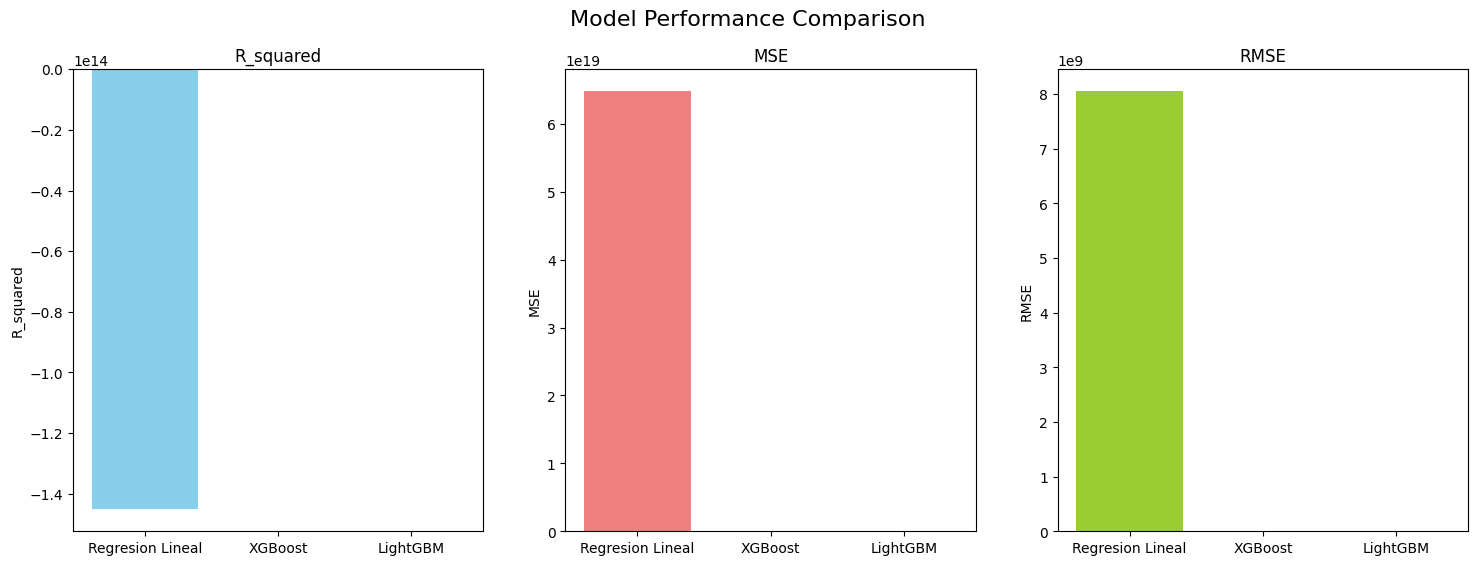

In [141]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# R_squared
ax[0].bar(df_results['model'], df_results['R_squared'], color='skyblue')
ax[0].set_title('R_squared')
ax[0].set_ylabel('R_squared')

# MSE
ax[1].bar(df_results['model'], df_results['MSE'], color='lightcoral')
ax[1].set_title('MSE')
ax[1].set_ylabel('MSE')

# RMSE
ax[2].bar(df_results['model'], df_results['RMSE'], color='yellowgreen')
ax[2].set_title('RMSE')
ax[2].set_ylabel('RMSE')

fig.suptitle('Model Performance Comparison', fontsize=16);

Basandonos en estos resultados, podemos decir que la regresión lineal definitivamente no es útil para este caso ya que las relaciones entre los datos y la variable a predecir no debe ser muy lineal. Sus resultados son pésimos.

Dado que la regresión lineal es tan comparativamente mala, los gráficos esconden la información que nos interesa, ya que buscamos valores más bajos para encontrar al mejor modelo.

Por eso volvemos a hacer este gráfico con solo los otros 2 modelos.

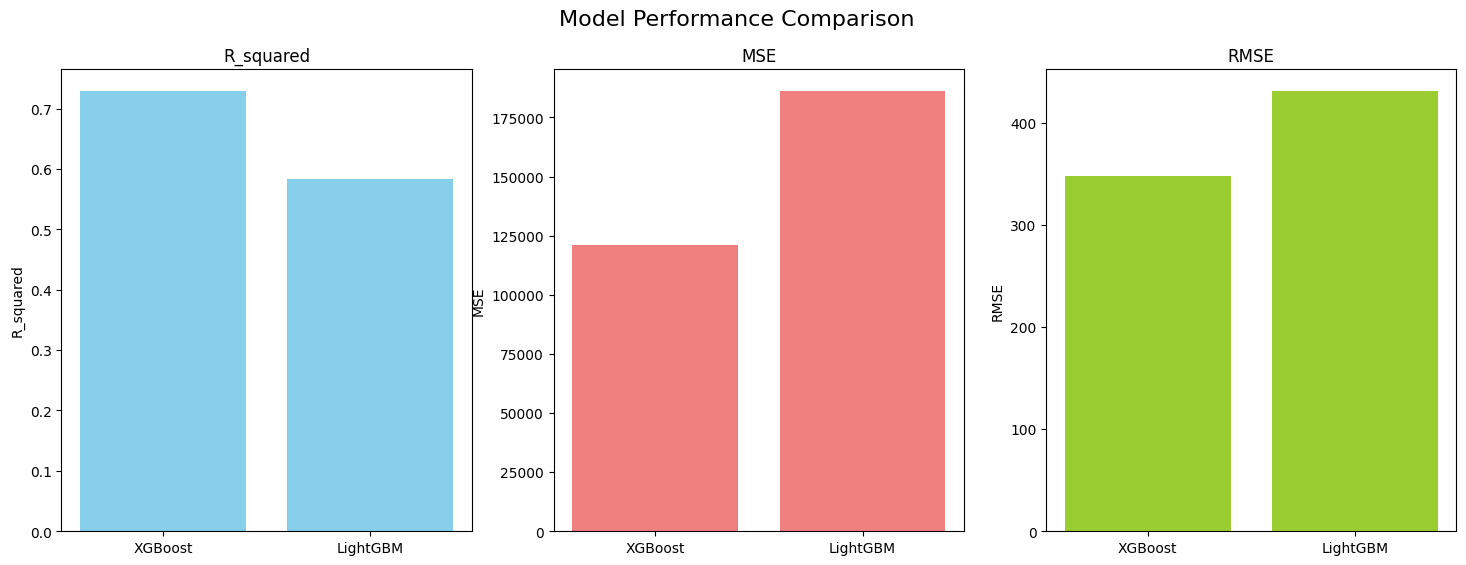

In [145]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
results = df_results[lambda df:df['model'].isin(['XGBoost', 'LightGBM'])]
# R_squared
ax[0].bar(results['model'], results['R_squared'], color='skyblue')
ax[0].set_title('R_squared')
ax[0].set_ylabel('R_squared')

# MSE
ax[1].bar(results['model'], results['MSE'], color='lightcoral')
ax[1].set_title('MSE')
ax[1].set_ylabel('MSE')

# RMSE
ax[2].bar(results['model'], results['RMSE'], color='yellowgreen')
ax[2].set_title('RMSE')
ax[2].set_ylabel('RMSE')

fig.suptitle('Model Performance Comparison', fontsize=16);

Entre XGBoost y LightGBM, podemos decir que sus resultados son similares pero XGBoost da un resultado un poco mejor con parametros de complejidad similares. Consideramos que las métricas MSE y RMSE son más significativas que el simple $r^2$, en espeical RMSE, ya que es directamente comparable con la variable objetivo teniendo las mismas unidades y dimensiones similares.

De todos modos, no obtuvimos diferencias muy significativas. Si tenemos en cuenta que la variación estándard en la variable precio es de ~\$727, obtuvimos resultados por debajo de eso.

XGBoost es nuestro predictor ganador.

# Pickling de los modelos y encoders

In [148]:
import joblib

pickle_data = {
    'linear': lr_model,
    "xgb": xgb_best_regressor,
    "third_model": best_lgb,
    "preprocessor": preprocessor
}

with open("ejer3.joblib", "wb") as f:
  joblib.dump(pickle_data, f)
